### Tiny Imagenet Visual Recognition Challenge

Tiny Imagenet has 200 Classes, each class has 500 traininig images, 50 Validation Images and 50 test images. Label Classes and Bounding Boxes are provided. More details can be found at https://tiny-imagenet.herokuapp.com/

This challenge is part of Stanford Class CS 213N

In [11]:
import os
import matplotlib
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import zipfile
import requests, StringIO
from sklearn import preprocessing


BATCH_SIZE = 10
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = BATCH_SIZE
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
TRAINING_IMAGES_DIR = './tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = './tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

def download_images(url):
    if (os.path.isdir(TRAINING_IMAGES_DIR)):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(StringIO.StringIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()

def load_training_images(image_dir, batch_size=500):
    labels = []
    names = []
    image_index = 0
    
    images = np.ndarray(shape=(NUM_IMAGES, IMAGE_ARR_SIZE))
                        
    
    # Loop through all the types directories
    for type in os.listdir(image_dir):
        if os.path.isdir(image_dir + type + '/images/'):
            type_images = os.listdir(image_dir + type + '/images/')
            # Loop through all the images of a type directory
            batch_index = 0;
            
            for image in type_images:
                image_file = os.path.join(image_dir, type + '/images/', image)

                # reading the images as they are; no normalization, no color editing
                image_data = mpimg.imread(image_file) 
                #print ('Loaded Image', image_file, image_data.shape)
                if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
                    images[image_index, :] = image_data.flatten()
                    image_index += 1
                    labels.append(type)
                    names.append(image)
                    batch_index += 1
                if (batch_index >= batch_size):
                    break;
                    
    return (images, np.asarray(labels), np.asarray(names))

def get_label_from_name(data, name):
    for idx, row in data.iterrows():
        
        if (row['File'] == name):
            return row['Class']
        
    return None


def load_validation_images(testdir, validation_data, batch_size=NUM_VAL_IMAGES):
    labels = []
    names = []
    image_index = 0
    
    images = np.ndarray(shape=(batch_size, IMAGE_ARR_SIZE))
    val_images = os.listdir(testdir + '/images/')
           
    # Loop through all the images of a val directory
    batch_index = 0;
            
    for image in val_images:
        image_file = os.path.join(testdir, 'images/', image)
        #print (testdir, image_file)

        # reading the images as they are; no normalization, no color editing
        image_data = mpimg.imread(image_file) 
        if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
            images[image_index, :] = image_data.flatten()
            image_index += 1
            labels.append(get_label_from_name(validation_data, image))
            names.append(image)
            batch_index += 1
            
        if (batch_index >= batch_size):
            break;
                    
    return (images, np.asarray(labels), np.asarray(names))
   
    

def plot_object(data):
    plt.figure(figsize=(1,1))
    image = data.reshape(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

def plot_objects(instances, images_per_row=10, **options):
    size = IMAGE_SIZE
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size,NUM_CHANNELS) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")
    plt.show()
    
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [12]:
height = IMAGE_SIZE
width = IMAGE_SIZE
channels = NUM_CHANNELS
n_inputs = height * width * channels

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 200

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 8 * 8])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Images already downloaded...


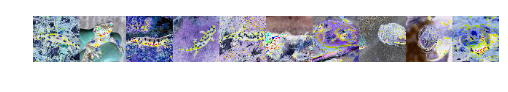

[1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


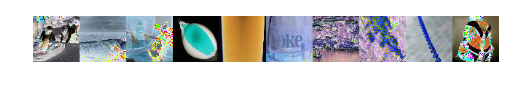

[107 139  90 138  67 135 198  38  88  63]
[]
((0, 12288), (0,))
[1 1 1 1 1 1 1 1 1 1]
((10, 12288), (10,))


InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [40,200] and labels shape [10]
	 [[Node: train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](output/output/BiasAdd, _arg_inputs/y_0_1)]]

Caused by op u'train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-4dcfcbb3ccc8>", line 47, in <module>
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 1690, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 2486, in _sparse_softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must have the same first dimension, got logits shape [40,200] and labels shape [10]
	 [[Node: train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](output/output/BiasAdd, _arg_inputs/y_0_1)]]


In [15]:
download_images(IMAGES_URL)
training_images, training_labels, training_files = load_training_images(TRAINING_IMAGES_DIR, batch_size=BATCH_SIZE)
le = preprocessing.LabelEncoder()
training_le = le.fit(training_labels)
training_labels_encoded = training_le.transform(training_labels)
plot_objects(training_images[15:30])
print (training_labels_encoded[15:30])

val_data = pd.read_csv(VAL_IMAGES_DIR + 'val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_images, val_labels, val_files = load_validation_images(VAL_IMAGES_DIR, val_data, batch_size=50)
val_labels_encoded = training_le.transform(val_labels)
plot_objects(val_images[0:10])
print (val_labels_encoded[0:10])

def get_next_batch(cursor, batchsize=50):
    if (cursor >= TRAIN_SIZE):
        cursor = 0
    X_batch, y_batch = training_images[cursor:cursor+batchsize], training_labels_encoded[cursor:cursor+batchsize]
    cursor = cursor + batchsize
    return cursor, X_batch, np.array(y_batch)

n_epochs = 10
batch_size = 10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        cursor = 0
        for iteration in range(TRAIN_SIZE // batch_size):
            cursor, X_batch, y_batch = get_next_batch(batch_size, cursor)
            print (y_batch)
            print (X_batch.shape, y_batch.shape)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
       
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: val_images, y: val_labels_encoded})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./tiny_imagenet")